# Import packages

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import copy

# Define own functions

In [2]:
def centrality_norm_diff(candidate_dict,true_dict):
    
    """Computes the difference of the centrality scores
    given 2 dictionaries"""
    
    score = 0
    for key, val in candidate_dict.items():
        score += np.linalg.norm(val-true_dict[key])
        
        
    return score

In [3]:
def network_preprocessing(date,method,ts_type,dy_threshold):
    
    """Import the network adjacency matrix from a .csv file, converts it into a networkx
    diGraph object"""
    
    # Convert date to string
    final_date_transformed = date.replace("-","_")
    
    
    # Import file
    filename = "./Data/Estimated_networks/" +\
                  method+"_"+ts_type+"_"+final_date_transformed+".csv"

    if method == "DY":
        network_matrix = np.genfromtxt(filename,
                              delimiter=',',skip_header = 1,usecols = np.arange(1,11),
                                   skip_footer=1)
        
        # Make the diagonal zero
        np.fill_diagonal(network_matrix, 0)
        
        # Delete link if the edge weight is too small in case of DY
        network_matrix[network_matrix<dy_threshold] = 0
        
        # Normalize values
        network_matrix = network_matrix / 100
        
        print(network_matrix)
        
    else:
        network_matrix = np.genfromtxt(filename,
                              delimiter=',',skip_header = 1,usecols = np.arange(1,11))
    
    
    # Convert it into networkX object
    network = nx.from_numpy_matrix(network_matrix, create_using=nx.DiGraph)
    
    return network

In [4]:
def centrality_ranking_df(centrality_type,networks,varnames,cross_holding_network=None):
    
    """Creates a dataframe with the sorted centrality of stocks
    from different methods"""
    
    # Add the cross-holding network to the dictionary (optional)
    if cross_holding_network is not None:
        networks['CH'] = cross_holding_network
        
    
    
    # Loop over different methods and their networks
    for key,val in networks.items():
        
    
        if centrality_type == "katz-bonacich":

            centrality_dict = nx.katz_centrality(val)     
            ticker_names = [varnames[k] for k, v in sorted(centrality_dict.items(),
                                                     key=lambda item: item[1],reverse=True)]
            
        elif centrality_type == "betweenness":
            
            centrality_dict = nx.betweenness_centrality(val)
            ticker_names = [varnames[k] for k, v in sorted(centrality_dict.items(),
                                                     key=lambda item: item[1],reverse=True)]            
        else:
            ticker_names = None
            
        networks[key] = ticker_names

    
    # Create dataframe
    df = pd.DataFrame(networks)
    
    return df

In [5]:
def rank_viz(varnames,ranking_df,centrality_type,date,ts_type):
    
    fig = plt.figure(figsize=(8,3.))
    ax = fig.add_subplot(111)
    col = 'white'
    
    cols = ranking_df.columns
    #print(cols)
    #print(varnames)
    
    n = len(varnames)
    d = len(cols)
    palette = iter(sns.color_palette("Paired", n))

    y_max = np.ones(d)*n
    x = np.arange(0,d,1)
    
    names = np.asarray(copy.deepcopy(varnames))
    
    for stock in varnames:
        stock_list = []
        counter = 0
        #print(stock)
        for i in cols:
            #print(i)
            #print(stock)
            
            
            temp = ranking_df[ranking_df[i]==stock].index.values[0]
            
            if counter == 0:
                #print(stock)
                #print(temp)
                names[n-temp-1] = stock

            stock_list.append(temp)
            
            
            
            ax.annotate(str(temp+1), xy=(counter,n - temp), color=col,
                fontsize=8, weight='heavy',
                horizontalalignment='center',
                verticalalignment='center')
            
            counter += 1

        yn = y_max-np.asarray(stock_list)
        #print(yn)

        

        ax.plot(x,yn, color=next(palette), linewidth=5)
        
    palette = iter(sns.color_palette("Paired", n))   
    for stock in varnames:
        stock_list = []
        counter = 0
        for i in cols:
            temp = ranking_df[ranking_df[i]==stock].index.values[0]
            
            stock_list.append(temp)
            
            counter += 1
            
        ax.plot(x,y_max - np.asarray(stock_list), '.', markersize=26, mec='w', mfc=next(palette))
    
    plt.xticks(range(d))
    plt.yticks(np.arange(1,n+1,1))
    plt.gca().get_yaxis().set_ticklabels(names)
    plt.gca().get_xaxis().set_ticklabels(cols)
    ax.set_facecolor('gainsboro')
    plt.tight_layout()
    
    # Convert date to string
    final_date_transformed = date.replace("-","_")
    plt.savefig('./Figures/ranking_comparison_{}_{}_{}.pdf'.format(ts_type,final_date_transformed,
                                                                 centrality_type),dpi=120)
    plt.show()

# Import data

## Cross-holdings

In [6]:
# SPECIFY BY DATE HERE TOO!
CH = pd.read_excel('./Data/nasdaq_normalized_cross_holdings.xlsx')
CH = np.array(CH)

In [7]:
CH.shape

(10, 11)

In [8]:
stock_names = CH[:,0]

CH = CH[:,1:]

In [9]:
CH = np.asarray(CH,dtype=np.float64)

In [10]:
# Convert it into networkX object
CH_network = nx.from_numpy_matrix(CH, create_using=nx.DiGraph)

## Estimated networks

In [11]:
# Parameters
date = "2020-06-30"
ts_type = "return"
dy_threshold = 10.5

# Iterables
methods = ['NS','SPACE','GLASSO','DY','DAG']

# Create dictionary to store the outputs
networks = {}

for method in methods:
    
    networks[method] = network_preprocessing(date,method,ts_type,dy_threshold)

[[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.1096 0.     0.     0.     0.1057 0.     0.     0.    ]
 [0.     0.1077 0.     0.     0.     0.     0.1055 0.     0.     0.    ]
 [0.     0.     0.1061 0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.1053 0.     0.     0.     0.1076 0.     0.     0.    ]
 [0.1076 0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.1074 0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.1064 0.     0.     0.     0.1104 0.     0.     0.    ]]


# Centrality measure comparisons

In [12]:
# Parameters
varnames = ["MS","JPM","BAC","C","WFC","GS","USB","TD","BK","TFC"]
centrality_type = "betweenness" #"betweenness" #"katz-bonacich"
cross_holdings = True

# Create centrality rankings
if cross_holdings:
    ranking_df = centrality_ranking_df(centrality_type,networks,varnames,
                                      CH_network) # cross-holdings network is optional!
else:
    ranking_df = centrality_ranking_df(centrality_type,networks,varnames)




# Inspect the dataframe
display(ranking_df)

,NS,SPACE,GLASSO,DY,DAG,CH
0,MS,BAC,MS,BAC,C,JPM
1,BAC,C,JPM,MS,JPM,GS
2,C,JPM,BAC,JPM,WFC,BK
3,JPM,MS,C,C,USB,BAC
4,USB,WFC,WFC,WFC,MS,MS
5,TFC,TD,GS,GS,BAC,C
6,TD,USB,USB,USB,GS,WFC
7,WFC,GS,TD,TD,TD,USB
8,GS,BK,BK,BK,BK,TD
9,BK,TFC,TFC,TFC,TFC,TFC


# Ranking visualisation

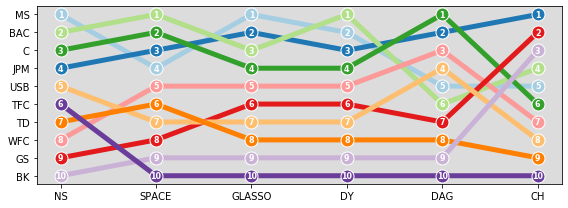

In [13]:
# Run the visualisation function
rank_viz(varnames,ranking_df,centrality_type,date,ts_type)

# Support

In [17]:
date = "2020-03-05"
method = "DY"
ts_type = "return"

temp = network_preprocessing(date,method,ts_type)

In [15]:

date = "2020-03-05"
final_date_transformed = date.replace("-","_")
method = "DY"
ts_type = "return"

filename = "./Data/Estimated_networks/" +\
                  method+"_"+ts_type+"_"+final_date_transformed+".csv"

NE_estimated_matrix = np.genfromtxt(filename,
                              delimiter=',',skip_header = 1,usecols = np.arange(1,11),
                                   skip_footer=1)

print(NE_estimated_matrix.shape)
print(NE_estimated_matrix)

CH_G = nx.from_numpy_matrix(NE_estimated_matrix, create_using=nx.DiGraph)

(10, 10)
[[16.2  10.78 11.4  11.37  8.15 11.94  9.15  6.58  5.83  8.6 ]
 [ 9.54 14.49 12.07 11.52  8.41 10.36 10.66  6.6   6.58  9.76]
 [10.03 11.59 13.63 11.36  8.58 10.24 10.75  6.97  7.12  9.72]
 [10.19 11.81 11.98 14.38  8.42 10.59  9.53  7.    6.9   9.2 ]
 [ 9.01 10.51 11.13 10.14 16.98  9.01 10.71  6.33  6.19  9.99]
 [11.35 11.28 11.45 11.23  7.97 15.26  9.18  6.89  6.16  9.23]
 [ 8.9  11.47 11.83 10.11  8.94  9.12 15.3   6.43  6.87 11.03]
 [ 9.18  9.61 10.92  9.98  7.43  9.45  9.31 19.93  5.72  8.48]
 [ 7.39 10.   10.89 10.33  7.05  8.68  9.66  5.24 22.67  8.1 ]
 [ 8.74 11.03 11.31 10.18  9.03  9.58 11.85  6.46  5.88 15.95]]
